In [2]:
############################################
#inicializando o Spark e carregando os dados
############################################
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan

# Initialize a Spark session
# Iniciar uma sessão Spark
spark = SparkSession.builder \
    .appName("Titanic Survival Prediction") \
    .getOrCreate()

# Importando os dados
titanic_df = spark.read.csv("/user/titanic.csv", inferSchema=True, header=True, sep=";")

# Display DataFrame schema and some data points
titanic_df.printSchema()
titanic_df.show(5)

# Count missing values
for column in titanic_df.columns:
    missing_count = titanic_df.filter((isnan(titanic_df[column])) | (titanic_df[column] == "")).count()
    print(f"Number of missing or empty entries in {column}: {missing_count}")


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 0) / 1]
Traceback (most recent call last):
  File "/opt/hadoop/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/hadoop/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
###########################
#Pré-processamento de dados
###########################

# Fill missing values
titanic_df = titanic_df.fillna({
    "HomeDest": "Nao Informado",
    "Cabin": "Nao Informado",
    "Ticket": "0",
    "Fare": 0,
    "Embarked": "Z"
})

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

# Convert categorical variables to numeric indices
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_index").fit(titanic_df)
    for column in ["Sex", "Embarked", "SibSp", "ParCh"]
]

# Apply transformations
pipeline = Pipeline(stages=indexers)
titanic_df = pipeline.fit(titanic_df).transform(titanic_df)

# Select and rename necessary columns for modeling
titanic_df = titanic_df.select(
    col("Survived").alias("label"),
    col("Class").alias("Pclass"),
    col("Sex_index").alias("Sex"),
    "Age",
    "SibSp_index",
    "ParCh_index",
    "Fare",
    "Embarked_index"
)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
###########################
#Seleção de feature
###########################

from pyspark.ml.feature import VectorAssembler

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["Pclass", "Sex", "Age", "SibSp_index", "ParCh_index", "Fare", "Embarked_index"],
    outputCol="features",
    handleInvalid="skip"
)
titanic_df = assembler.transform(titanic_df)


In [ ]:
#################################################
#Treinamento de modelo e avaliação de performance
#################################################

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Split the data into training and test sets
(train_data, test_data) = titanic_df.randomSplit([0.7, 0.3], seed=1234)

# Train a Decision Tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Setup the binary evaluator
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

# Create parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 32, 40]) \
    .build()

# Setup cross-validation
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit the model
cvModel = crossval.fit(train_data)

# Fetch best model and evaluate on test data
bestModel = cvModel.bestModel
predictions = bestModel.transform(test_data)
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC Score: {roc_auc}")


ROC-AUC Score: 0.7800347222222221


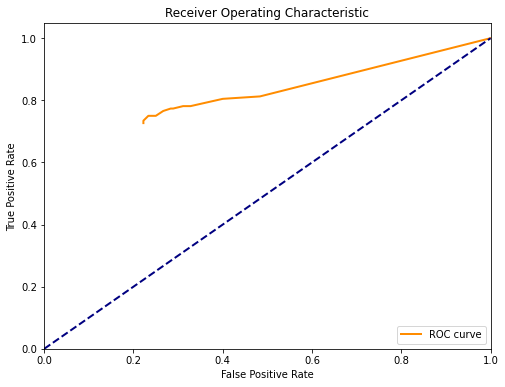

In [ ]:
#################################################
#Plotando a curva ROC
#################################################

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt

# Define a UDF to extract the probability of the positive class
def extract_probability(probability_vector):
    return float(probability_vector[1])

extract_prob_udf = udf(extract_probability, FloatType())

# Update the DataFrame to include a column for the positive class probability
predictions = predictions.withColumn("positive_probability", extract_prob_udf("probability"))

# Now compute the ROC curve
thresholds = [i / 100.0 for i in range(100)]  # Creating a list of threshold values from 0 to 1
roc_points = []

for threshold in thresholds:
    # Create a new column 'predicted_label' based on the probability threshold
    prediction_with_threshold = predictions.withColumn('predicted_label', (col("positive_probability") >= threshold).cast("integer"))

    # True Positive (TP): correctly predicted positive observations
    TP = prediction_with_threshold.filter('predicted_label = 1 AND label = 1').count()
    # False Positive (FP): incorrectly predicted positive observations
    FP = prediction_with_threshold.filter('predicted_label = 1 AND label = 0').count()
    # True Negative (TN): correctly predicted negative observations
    TN = prediction_with_threshold.filter('predicted_label = 0 AND label = 0').count()
    # False Negative (FN): incorrectly predicted negative observations
    FN = prediction_with_threshold.filter('predicted_label = 0 AND label = 1').count()
    
    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    TPR = TP / (TP + FN) if (TP + FN) else 0
    FPR = FP / (FP + TN) if (FP + TN) else 0
    
    roc_points.append((FPR, TPR))

# Extract FPR and TPR into separate lists for plotting
fpr, tpr = zip(*roc_points)

# Plot ROC curve using Matplotlib
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



